# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Helper functions
Set of helper functions

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Configuration Class
A simple class to manage configuration

In [3]:
# periocular face 학습
# class Config():
#     training_dir = "./data/db_periocular/train"
#     train_batch_size = 64
#     train_number_epochs = 300
#     testing_dir = "./data/db_periocular/test"

#full face 학습
class Config():
    training_dir = "./data/db_cropped_face/train"
    train_batch_size = 64
    train_number_epochs = 300
    testing_dir = "./data/db_cropped_face/test"

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [4]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #print (img0_tuple[1]) : folder name
        #we need to make sure approx 50% of images are in the same class
        #print ("img0 ",img0_tuple[0], img0_tuple[1])
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                
                if ((img0_tuple[1]==img1_tuple[1]) and (img0_tuple[0] != img1_tuple[0])):
                    #print ("img1 ", img1_tuple[0], "genuine", img1_tuple[1])
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                
                if img0_tuple[1] !=img1_tuple[1]:
                    #print ("img1 ", img1_tuple[0],"imposter",img1_tuple[1])
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            
        img0_folder=os.path.dirname(img0_tuple[0])[-4:]
        img1_folder=os.path.dirname(img1_tuple[0])[-4:]
        
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32)) , img0_folder, img1_folder, img0_tuple[0],img1_tuple[0]
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [5]:
import os
__file__="./dataset/db_periocular/train/0023/23_1_resized.jpg"

print(os.path.dirname(__file__)[-4:])

0023


## Using Image Folder Dataset

In [6]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [14]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((105,105)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

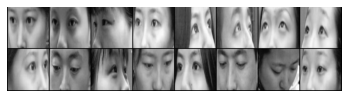

위 폴더 ('0287', '0008', '0093', '0498', '0610', '0842', '0174', '0645')
아래 폴더 ('0287', '0878', '0093', '0498', '0610', '0842', '0497', '0645')
genuine matching [0.]
Imposter matching [1.]
genuine matching [0.]
genuine matching [0.]
genuine matching [0.]
genuine matching [0.]
Imposter matching [1.]
genuine matching [0.]


In [28]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=8)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)

#imshow(torch.cat((example_batch[0],example_batch[1]),0))
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))

print ("위 폴더", example_batch[3])
print ("아래 폴더", example_batch[4])

for i in example_batch[2].numpy():
    if i == 1 : 
        print ("Imposter matching",i)
    else:
        print ("genuine matching", i)
#print(example_batch[2].numpy())

In [29]:
example_batch[0].shape

torch.Size([8, 1, 105, 105])

## Neural Net Definition
We will use a standard convolutional neural network

In [10]:
# # 변경 전

# class SiameseNetwork(nn.Module):
#     def __init__(self):
#         super(SiameseNetwork, self).__init__()
#         self.cnn1 = nn.Sequential(
#             nn.ReflectionPad2d(1),
#             nn.Conv2d(1, 4, kernel_size=3),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(4),
            
#             nn.ReflectionPad2d(1),
#             nn.Conv2d(4, 8, kernel_size=3),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(8),


#             nn.ReflectionPad2d(1),
#             nn.Conv2d(8, 8, kernel_size=3),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(8),


#         )

#         self.fc1 = nn.Sequential(
#             nn.Linear(8*100*100, 500),
#             nn.ReLU(inplace=True),

#             nn.Linear(500, 500),
#             nn.ReLU(inplace=True),

#             nn.Linear(500, 5))

#     def forward_once(self, x):
#         output = self.cnn1(x)
#         output = output.view(output.size()[0], -1)
#         output = self.fc1(output)
#         return output

#     def forward(self, input1, input2):
#         output1 = self.forward_once(input1)
#         output2 = self.forward_once(input2)
#         return output1, output2

In [7]:
# 변경 후

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            # Conv2d: 입력채널 수, 출력채널 수, 필터크기, 패딩
            nn.Conv2d(1, 64, kernel_size=10, padding=0), # 105*105*1 → 96*96*64
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            
            nn.MaxPool2d((2,2), stride=(2, 2)), # 96*96*64 → 48*48*64
            
            nn.Conv2d(64, 128, kernel_size=7, padding=0), # 48*48*64 → 42*42*128
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            
            nn.MaxPool2d((2,2), stride=(2, 2)), # 42*42*128 → 21*21*128

            nn.Conv2d(128, 128, kernel_size=4, padding=0), # 21*21*128 → 18*18*128
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            
            nn.MaxPool2d((2,2), stride=(2, 2)), # 18*18*128 → 9*9*128
            
            nn.Conv2d(128, 256, kernel_size=4, padding=0), # 9*9*128 → 6*6*256 (9*9*256)
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(6*6*256, 4096), # 6*6*256=9216 → 4096
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(4096), # 1줄 → BatchNorm1d
            
            nn.Linear(4096, 1000), # 4096 → 1000
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1000), # 1줄 → BatchNorm1d
            
            nn.Linear(1000, 100)) # 1000 → 100


    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [8]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        # min=0.0은 0 미만의 값을 사용하지 않을거라는 의미. → max 함수의 결과가 0인 것과 같음.

        return loss_contrastive

## Training Time!

In [15]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=Config.train_batch_size)

In [20]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
#optimizer = optim.RMSprop(net.parameters(), lr=1e-2) # 하이퍼파라미터 변경
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

In [21]:
counter = []
loss_history = [] 
iteration_number= 0

In [22]:
import os

Epoch number 0
 Current loss 31.066144943237305

Epoch number 0
 Current loss 5.372156620025635

Epoch number 0
 Current loss 2.5381646156311035

Epoch number 0
 Current loss 1.8015213012695312

Epoch number 0
 Current loss 1.5173063278198242

Epoch number 0
 Current loss 1.1675821542739868

Epoch number 0
 Current loss 1.1257646083831787

Epoch number 0
 Current loss 0.9334719181060791

Epoch number 0
 Current loss 1.3382841348648071

Epoch number 0
 Current loss 0.9627669453620911

Epoch number 0
 Current loss 0.9973806142807007

Epoch number 0
 Current loss 0.7449770569801331

Epoch number 0
 Current loss 1.0505974292755127

Epoch number 0
 Current loss 1.0621817111968994

Epoch number 0
 Current loss 1.0710411071777344

Epoch number 0
 Current loss 0.8601444959640503

Epoch number 0
 Current loss 1.159603476524353

Epoch number 0
 Current loss 1.2711560726165771

Epoch number 0
 Current loss 0.965744137763977

Epoch number 0
 Current loss 0.8474487066268921

Epoch number 0
 Current

C:\ProgramData\Anaconda3\envs\jihye\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type SiameseNetwork. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch number 1
 Current loss 0.9281055927276611

Epoch number 1
 Current loss 0.8910146355628967

Epoch number 1
 Current loss 0.9669017791748047

Epoch number 1
 Current loss 0.9653635025024414

Epoch number 1
 Current loss 0.7939957976341248

Epoch number 1
 Current loss 0.88216233253479

Epoch number 1
 Current loss 0.9542492628097534

Epoch number 1
 Current loss 0.9097768068313599

Epoch number 1
 Current loss 0.74882972240448

Epoch number 1
 Current loss 1.166818380355835

Epoch number 1
 Current loss 0.9600883722305298

Epoch number 1
 Current loss 0.8122367858886719

Epoch number 1
 Current loss 0.8802368640899658

Epoch number 1
 Current loss 0.9276517033576965

Epoch number 1
 Current loss 1.0368517637252808

Epoch number 1
 Current loss 0.909639835357666

Epoch number 1
 Current loss 0.9186828136444092

Epoch number 1
 Current loss 0.8736557960510254

Epoch number 1
 Current loss 0.8633425235748291

Epoch number 1
 Current loss 0.9718564748764038

Epoch number 1
 Current lo

Epoch number 6
 Current loss 0.545455813407898

Epoch number 6
 Current loss 0.5773442983627319

Epoch number 6
 Current loss 0.5692506432533264

Epoch number 6
 Current loss 0.7016488909721375

Epoch number 6
 Current loss 0.4573064148426056

Epoch number 6
 Current loss 0.45917630195617676

Epoch number 6
 Current loss 0.5473959445953369

Epoch number 6
 Current loss 0.3417041599750519

Epoch number 6
 Current loss 0.4409341812133789

Epoch number 6
 Current loss 0.5773351192474365

Epoch number 6
 Current loss 0.5436925888061523

Epoch number 6
 Current loss 0.8589204549789429

Epoch number 6
 Current loss 0.6760809421539307

Epoch number 6
 Current loss 0.524719774723053

Epoch number 6
 Current loss 0.38675910234451294

Epoch number 6
 Current loss 0.6084707975387573

Epoch number 6
 Current loss 0.7376168966293335

Epoch number 6
 Current loss 0.5373987555503845

Epoch number 7
 Current loss 0.5018596649169922

Epoch number 7
 Current loss 0.6613471508026123

Epoch number 7
 Curr

Epoch number 11
 Current loss 0.4217650592327118

Epoch number 11
 Current loss 0.4191212058067322

Epoch number 11
 Current loss 0.44908320903778076

Epoch number 11
 Current loss 0.41811448335647583

Epoch number 11
 Current loss 0.4793054163455963

Epoch number 11
 Current loss 0.4146643280982971

Epoch number 11
 Current loss 0.542568564414978

Epoch number 12
 Current loss 0.2737095355987549

Epoch number 12
 Current loss 0.5577479600906372

Epoch number 12
 Current loss 0.4395160973072052

Epoch number 12
 Current loss 0.4504265785217285

Epoch number 12
 Current loss 0.3777015805244446

Epoch number 12
 Current loss 0.42241421341896057

Epoch number 12
 Current loss 0.5095925331115723

Epoch number 12
 Current loss 0.4599434733390808

Epoch number 12
 Current loss 0.3973815441131592

Epoch number 12
 Current loss 0.34266197681427

Epoch number 12
 Current loss 0.3877514898777008

Epoch number 12
 Current loss 0.38393062353134155

Epoch number 12
 Current loss 0.4009625315666199


Epoch number 17
 Current loss 0.3094121217727661

Epoch number 17
 Current loss 0.44307780265808105

Epoch number 17
 Current loss 0.48142457008361816

Epoch number 17
 Current loss 0.4670339822769165

Epoch number 17
 Current loss 0.2671845257282257

Epoch number 17
 Current loss 0.3445092737674713

Epoch number 17
 Current loss 0.3848732113838196

Epoch number 17
 Current loss 0.33990633487701416

Epoch number 17
 Current loss 0.5499063730239868

Epoch number 17
 Current loss 0.45091402530670166

Epoch number 17
 Current loss 0.30917346477508545

Epoch number 17
 Current loss 0.26928532123565674

Epoch number 17
 Current loss 0.31330162286758423

Epoch number 17
 Current loss 0.2873144745826721

Epoch number 17
 Current loss 0.34010574221611023

Epoch number 17
 Current loss 0.3680393695831299

Epoch number 17
 Current loss 0.43583086133003235

Epoch number 17
 Current loss 0.4983491897583008

Epoch number 17
 Current loss 0.2889053225517273

Epoch number 17
 Current loss 0.339768081

Epoch number 22
 Current loss 0.43390971422195435

Epoch number 22
 Current loss 0.34443148970603943

Epoch number 22
 Current loss 0.3684437870979309

Epoch number 22
 Current loss 0.33001095056533813

Epoch number 22
 Current loss 0.37508419156074524

Epoch number 22
 Current loss 0.2983950972557068

Epoch number 22
 Current loss 0.3167200982570648

Epoch number 22
 Current loss 0.20950940251350403

Epoch number 22
 Current loss 0.36073070764541626

Epoch number 22
 Current loss 0.3725091218948364

Epoch number 22
 Current loss 0.2971224784851074

Epoch number 22
 Current loss 0.3767211139202118

Epoch number 22
 Current loss 0.2792983055114746

Epoch number 22
 Current loss 0.2154916524887085

Epoch number 22
 Current loss 0.31496769189834595

Epoch number 22
 Current loss 0.33670806884765625

Epoch number 22
 Current loss 0.3484601378440857

Epoch number 22
 Current loss 0.2997676134109497

Epoch number 22
 Current loss 0.3632245659828186

Epoch number 22
 Current loss 0.2897785902

Epoch number 27
 Current loss 0.31669801473617554

Epoch number 27
 Current loss 0.2697402834892273

Epoch number 27
 Current loss 0.3259161114692688

Epoch number 27
 Current loss 0.32972481846809387

Epoch number 27
 Current loss 0.40205371379852295

Epoch number 27
 Current loss 0.22469593584537506

Epoch number 27
 Current loss 0.3632594347000122

Epoch number 27
 Current loss 0.3866325318813324

Epoch number 27
 Current loss 0.28788673877716064

Epoch number 27
 Current loss 0.3365491032600403

Epoch number 27
 Current loss 0.24405255913734436

Epoch number 27
 Current loss 0.3249349594116211

Epoch number 27
 Current loss 0.2815542221069336

Epoch number 27
 Current loss 0.3821372985839844

Epoch number 28
 Current loss 0.3480817973613739

Epoch number 28
 Current loss 0.31609654426574707

Epoch number 28
 Current loss 0.2276211977005005

Epoch number 28
 Current loss 0.4675154685974121

Epoch number 28
 Current loss 0.23276644945144653

Epoch number 28
 Current loss 0.3862166404

Epoch number 32
 Current loss 0.2921558916568756

Epoch number 32
 Current loss 0.39895138144493103

Epoch number 32
 Current loss 0.38202518224716187

Epoch number 32
 Current loss 0.3854885697364807

Epoch number 32
 Current loss 0.23755136132240295

Epoch number 32
 Current loss 0.32444512844085693

Epoch number 33
 Current loss 0.30451685190200806

Epoch number 33
 Current loss 0.205134779214859

Epoch number 33
 Current loss 0.30431559681892395

Epoch number 33
 Current loss 0.3294644355773926

Epoch number 33
 Current loss 0.22632917761802673

Epoch number 33
 Current loss 0.33280786871910095

Epoch number 33
 Current loss 0.23187920451164246

Epoch number 33
 Current loss 0.31160038709640503

Epoch number 33
 Current loss 0.34982919692993164

Epoch number 33
 Current loss 0.38613349199295044

Epoch number 33
 Current loss 0.30778205394744873

Epoch number 33
 Current loss 0.4836764931678772

Epoch number 33
 Current loss 0.4164160490036011

Epoch number 33
 Current loss 0.409098

Epoch number 38
 Current loss 0.30402088165283203

Epoch number 38
 Current loss 0.3234494924545288

Epoch number 38
 Current loss 0.23787108063697815

Epoch number 38
 Current loss 0.3280329406261444

Epoch number 38
 Current loss 0.23500744998455048

Epoch number 38
 Current loss 0.28250113129615784

Epoch number 38
 Current loss 0.24719983339309692

Epoch number 38
 Current loss 0.22174318134784698

Epoch number 38
 Current loss 0.26235896348953247

Epoch number 38
 Current loss 0.29972171783447266

Epoch number 38
 Current loss 0.2356378138065338

Epoch number 38
 Current loss 0.2355446070432663

Epoch number 38
 Current loss 0.28481534123420715

Epoch number 38
 Current loss 0.1257731020450592

Epoch number 38
 Current loss 0.28440696001052856

Epoch number 38
 Current loss 0.2874196469783783

Epoch number 38
 Current loss 0.1681300401687622

Epoch number 38
 Current loss 0.19053569436073303

Epoch number 38
 Current loss 0.20839636027812958

Epoch number 38
 Current loss 0.305542

Epoch number 43
 Current loss 0.2567046880722046

Epoch number 43
 Current loss 0.24297501146793365

Epoch number 43
 Current loss 0.23816360533237457

Epoch number 43
 Current loss 0.25631096959114075

Epoch number 43
 Current loss 0.2829951047897339

Epoch number 43
 Current loss 0.27345579862594604

Epoch number 43
 Current loss 0.26362425088882446

Epoch number 43
 Current loss 0.21409925818443298

Epoch number 43
 Current loss 0.2672470211982727

Epoch number 43
 Current loss 0.22530697286128998

Epoch number 43
 Current loss 0.18903404474258423

Epoch number 43
 Current loss 0.2550406754016876

Epoch number 43
 Current loss 0.2950212359428406

Epoch number 43
 Current loss 0.2252914011478424

Epoch number 43
 Current loss 0.20808568596839905

Epoch number 43
 Current loss 0.16650515794754028

Epoch number 43
 Current loss 0.2801700234413147

Epoch number 43
 Current loss 0.3274546265602112

Epoch number 43
 Current loss 0.24930298328399658

Epoch number 43
 Current loss 0.2601894

Epoch number 48
 Current loss 0.20289026200771332

Epoch number 48
 Current loss 0.1632290780544281

Epoch number 48
 Current loss 0.14551368355751038

Epoch number 48
 Current loss 0.2904519736766815

Epoch number 48
 Current loss 0.29264768958091736

Epoch number 48
 Current loss 0.19832520186901093

Epoch number 48
 Current loss 0.16728919744491577

Epoch number 48
 Current loss 0.22317296266555786

Epoch number 48
 Current loss 0.26192545890808105

Epoch number 48
 Current loss 0.24166938662528992

Epoch number 48
 Current loss 0.30982571840286255

Epoch number 48
 Current loss 0.1817607581615448

Epoch number 48
 Current loss 0.2931075990200043

Epoch number 48
 Current loss 0.2725512385368347

Epoch number 49
 Current loss 0.1850828230381012

Epoch number 49
 Current loss 0.19111786782741547

Epoch number 49
 Current loss 0.21787135303020477

Epoch number 49
 Current loss 0.24411222338676453

Epoch number 49
 Current loss 0.2337508499622345

Epoch number 49
 Current loss 0.289304

Epoch number 53
 Current loss 0.27569758892059326

Epoch number 53
 Current loss 0.21265646815299988

Epoch number 53
 Current loss 0.2812265157699585

Epoch number 53
 Current loss 0.1947174370288849

Epoch number 53
 Current loss 0.1897447407245636

Epoch number 53
 Current loss 0.2568371891975403

Epoch number 53
 Current loss 0.26482945680618286

Epoch number 54
 Current loss 0.23896320164203644

Epoch number 54
 Current loss 0.13509635627269745

Epoch number 54
 Current loss 0.15123647451400757

Epoch number 54
 Current loss 0.1703316569328308

Epoch number 54
 Current loss 0.2169119268655777

Epoch number 54
 Current loss 0.2782987654209137

Epoch number 54
 Current loss 0.36178281903266907

Epoch number 54
 Current loss 0.2010420560836792

Epoch number 54
 Current loss 0.2190546691417694

Epoch number 54
 Current loss 0.21327586472034454

Epoch number 54
 Current loss 0.1961020529270172

Epoch number 54
 Current loss 0.20172610878944397

Epoch number 54
 Current loss 0.244967043

Epoch number 59
 Current loss 0.22230039536952972

Epoch number 59
 Current loss 0.2069246470928192

Epoch number 59
 Current loss 0.2873736023902893

Epoch number 59
 Current loss 0.16022837162017822

Epoch number 59
 Current loss 0.2437310814857483

Epoch number 59
 Current loss 0.15020787715911865

Epoch number 59
 Current loss 0.20700129866600037

Epoch number 59
 Current loss 0.23464816808700562

Epoch number 59
 Current loss 0.2632252275943756

Epoch number 59
 Current loss 0.2532866597175598

Epoch number 59
 Current loss 0.20780253410339355

Epoch number 59
 Current loss 0.20188561081886292

Epoch number 59
 Current loss 0.24501433968544006

Epoch number 59
 Current loss 0.20259054005146027

Epoch number 59
 Current loss 0.15390491485595703

Epoch number 59
 Current loss 0.17378440499305725

Epoch number 59
 Current loss 0.24289527535438538

Epoch number 59
 Current loss 0.20584744215011597

Epoch number 59
 Current loss 0.24553391337394714

Epoch number 59
 Current loss 0.2179

Epoch number 64
 Current loss 0.2278321087360382

Epoch number 64
 Current loss 0.16663819551467896

Epoch number 64
 Current loss 0.17633303999900818

Epoch number 64
 Current loss 0.22026516497135162

Epoch number 64
 Current loss 0.1840018779039383

Epoch number 64
 Current loss 0.14270389080047607

Epoch number 64
 Current loss 0.15747883915901184

Epoch number 64
 Current loss 0.1399225890636444

Epoch number 64
 Current loss 0.12913314998149872

Epoch number 64
 Current loss 0.2681189775466919

Epoch number 64
 Current loss 0.2675725221633911

Epoch number 64
 Current loss 0.18127062916755676

Epoch number 64
 Current loss 0.1753237247467041

Epoch number 64
 Current loss 0.17314773797988892

Epoch number 64
 Current loss 0.1512203812599182

Epoch number 64
 Current loss 0.2605414390563965

Epoch number 64
 Current loss 0.26229944825172424

Epoch number 64
 Current loss 0.11891728639602661

Epoch number 64
 Current loss 0.18207970261573792

Epoch number 64
 Current loss 0.1726103

Epoch number 69
 Current loss 0.1941474825143814

Epoch number 69
 Current loss 0.1975046694278717

Epoch number 69
 Current loss 0.21721819043159485

Epoch number 69
 Current loss 0.17474238574504852

Epoch number 69
 Current loss 0.1515762209892273

Epoch number 69
 Current loss 0.1919015496969223

Epoch number 69
 Current loss 0.26323074102401733

Epoch number 69
 Current loss 0.23055614531040192

Epoch number 69
 Current loss 0.16290944814682007

Epoch number 69
 Current loss 0.17614975571632385

Epoch number 69
 Current loss 0.2067309021949768

Epoch number 69
 Current loss 0.24856452643871307

Epoch number 69
 Current loss 0.13358479738235474

Epoch number 69
 Current loss 0.21265751123428345

Epoch number 69
 Current loss 0.18046291172504425

Epoch number 69
 Current loss 0.2221052646636963

Epoch number 70
 Current loss 0.19639068841934204

Epoch number 70
 Current loss 0.2062414586544037

Epoch number 70
 Current loss 0.14060889184474945

Epoch number 70
 Current loss 0.182236

Epoch number 74
 Current loss 0.14279378950595856

Epoch number 74
 Current loss 0.30854886770248413

Epoch number 74
 Current loss 0.15398383140563965

Epoch number 74
 Current loss 0.20592951774597168

Epoch number 74
 Current loss 0.2766357958316803

Epoch number 74
 Current loss 0.18034429848194122

Epoch number 74
 Current loss 0.18960519134998322

Epoch number 74
 Current loss 0.15230655670166016

Epoch number 74
 Current loss 0.24234169721603394

Epoch number 75
 Current loss 0.2195747345685959

Epoch number 75
 Current loss 0.2206040918827057

Epoch number 75
 Current loss 0.19302207231521606

Epoch number 75
 Current loss 0.2622232437133789

Epoch number 75
 Current loss 0.14896151423454285

Epoch number 75
 Current loss 0.21050259470939636

Epoch number 75
 Current loss 0.1787000149488449

Epoch number 75
 Current loss 0.15778407454490662

Epoch number 75
 Current loss 0.1851508617401123

Epoch number 75
 Current loss 0.14238184690475464

Epoch number 75
 Current loss 0.24865

Epoch number 79
 Current loss 0.12262336909770966

Epoch number 79
 Current loss 0.2183525711297989

Epoch number 80
 Current loss 0.14826136827468872

Epoch number 80
 Current loss 0.20598062872886658

Epoch number 80
 Current loss 0.2008972018957138

Epoch number 80
 Current loss 0.3290437161922455

Epoch number 80
 Current loss 0.28163379430770874

Epoch number 80
 Current loss 0.1786777675151825

Epoch number 80
 Current loss 0.09712165594100952

Epoch number 80
 Current loss 0.23781096935272217

Epoch number 80
 Current loss 0.09291727095842361

Epoch number 80
 Current loss 0.2143072783946991

Epoch number 80
 Current loss 0.11624348163604736

Epoch number 80
 Current loss 0.13046795129776

Epoch number 80
 Current loss 0.19677984714508057

Epoch number 80
 Current loss 0.17257298529148102

Epoch number 80
 Current loss 0.12330653518438339

Epoch number 80
 Current loss 0.13575787842273712

Epoch number 80
 Current loss 0.11217236518859863

Epoch number 80
 Current loss 0.1221517

Epoch number 85
 Current loss 0.1999242603778839

Epoch number 85
 Current loss 0.11414264142513275

Epoch number 85
 Current loss 0.2088865041732788

Epoch number 85
 Current loss 0.1342695653438568

Epoch number 85
 Current loss 0.13478101789951324

Epoch number 85
 Current loss 0.16651573777198792

Epoch number 85
 Current loss 0.10836857557296753

Epoch number 85
 Current loss 0.2293856143951416

Epoch number 85
 Current loss 0.20942480862140656

Epoch number 85
 Current loss 0.14473292231559753

Epoch number 85
 Current loss 0.19282054901123047

Epoch number 85
 Current loss 0.2130509614944458

Epoch number 85
 Current loss 0.11386479437351227

Epoch number 85
 Current loss 0.14755196869373322

Epoch number 85
 Current loss 0.1197059229016304

Epoch number 85
 Current loss 0.12166693061590195

Epoch number 85
 Current loss 0.23020794987678528

Epoch number 85
 Current loss 0.18916010856628418

Epoch number 85
 Current loss 0.18562528491020203

Epoch number 85
 Current loss 0.18765

Epoch number 90
 Current loss 0.15033064782619476

Epoch number 90
 Current loss 0.16041775047779083

Epoch number 90
 Current loss 0.1045745313167572

Epoch number 90
 Current loss 0.1987244337797165

Epoch number 90
 Current loss 0.19718608260154724

Epoch number 90
 Current loss 0.23193314671516418

Epoch number 90
 Current loss 0.19649754464626312

Epoch number 90
 Current loss 0.10856585204601288

Epoch number 90
 Current loss 0.16260157525539398

Epoch number 90
 Current loss 0.1806396096944809

Epoch number 90
 Current loss 0.19306580722332

Epoch number 90
 Current loss 0.21520212292671204

Epoch number 90
 Current loss 0.18174564838409424

Epoch number 90
 Current loss 0.16810986399650574

Epoch number 90
 Current loss 0.16203898191452026

Epoch number 90
 Current loss 0.1604405641555786

Epoch number 90
 Current loss 0.13847875595092773

Epoch number 90
 Current loss 0.22587665915489197

Epoch number 90
 Current loss 0.17484939098358154

Epoch number 91
 Current loss 0.158291

Epoch number 95
 Current loss 0.09216281026601791

Epoch number 95
 Current loss 0.16474825143814087

Epoch number 95
 Current loss 0.16324639320373535

Epoch number 95
 Current loss 0.24516239762306213

Epoch number 95
 Current loss 0.15818685293197632

Epoch number 95
 Current loss 0.2466410994529724

Epoch number 95
 Current loss 0.18563662469387054

Epoch number 95
 Current loss 0.14423993229866028

Epoch number 95
 Current loss 0.1763910949230194

Epoch number 95
 Current loss 0.08372564613819122

Epoch number 95
 Current loss 0.11775214970111847

Epoch number 95
 Current loss 0.1768171340227127

Epoch number 96
 Current loss 0.09660433232784271

Epoch number 96
 Current loss 0.15578752756118774

Epoch number 96
 Current loss 0.18267884850502014

Epoch number 96
 Current loss 0.13864997029304504

Epoch number 96
 Current loss 0.1588129997253418

Epoch number 96
 Current loss 0.18008767068386078

Epoch number 96
 Current loss 0.18448996543884277

Epoch number 96
 Current loss 0.114

Epoch number 100
 Current loss 0.13172028958797455

Epoch number 100
 Current loss 0.1773330569267273

Epoch number 100
 Current loss 0.18309271335601807

Epoch number 100
 Current loss 0.14384770393371582

Epoch number 100
 Current loss 0.1411084532737732

Epoch number 101
 Current loss 0.15414290130138397

Epoch number 101
 Current loss 0.2181738018989563

Epoch number 101
 Current loss 0.15788888931274414

Epoch number 101
 Current loss 0.1804824024438858

Epoch number 101
 Current loss 0.1437872350215912

Epoch number 101
 Current loss 0.17828312516212463

Epoch number 101
 Current loss 0.12623552978038788

Epoch number 101
 Current loss 0.15957513451576233

Epoch number 101
 Current loss 0.1357124000787735

Epoch number 101
 Current loss 0.1859530359506607

Epoch number 101
 Current loss 0.1658536195755005

Epoch number 101
 Current loss 0.14997392892837524

Epoch number 101
 Current loss 0.15613216161727905

Epoch number 101
 Current loss 0.1207587867975235

Epoch number 101
 Cur

Epoch number 105
 Current loss 0.23610326647758484

Epoch number 106
 Current loss 0.14563018083572388

Epoch number 106
 Current loss 0.1538373976945877

Epoch number 106
 Current loss 0.14175517857074738

Epoch number 106
 Current loss 0.15924817323684692

Epoch number 106
 Current loss 0.13828539848327637

Epoch number 106
 Current loss 0.19505582749843597

Epoch number 106
 Current loss 0.12211992591619492

Epoch number 106
 Current loss 0.08840025216341019

Epoch number 106
 Current loss 0.08831202983856201

Epoch number 106
 Current loss 0.1662823110818863

Epoch number 106
 Current loss 0.10852565616369247

Epoch number 106
 Current loss 0.13340100646018982

Epoch number 106
 Current loss 0.2354254424571991

Epoch number 106
 Current loss 0.17803847789764404

Epoch number 106
 Current loss 0.11020167171955109

Epoch number 106
 Current loss 0.21057434380054474

Epoch number 106
 Current loss 0.23811151087284088

Epoch number 106
 Current loss 0.24615296721458435

Epoch number 10

Epoch number 111
 Current loss 0.2466500699520111

Epoch number 111
 Current loss 0.1247633770108223

Epoch number 111
 Current loss 0.1418054699897766

Epoch number 111
 Current loss 0.11162325739860535

Epoch number 111
 Current loss 0.14177745580673218

Epoch number 111
 Current loss 0.17116239666938782

Epoch number 111
 Current loss 0.2578583061695099

Epoch number 111
 Current loss 0.16708701848983765

Epoch number 111
 Current loss 0.18226540088653564

Epoch number 111
 Current loss 0.10784068703651428

Epoch number 111
 Current loss 0.192411869764328

Epoch number 111
 Current loss 0.07209082692861557

Epoch number 111
 Current loss 0.17183056473731995

Epoch number 111
 Current loss 0.13753467798233032

Epoch number 111
 Current loss 0.1754157841205597

Epoch number 111
 Current loss 0.10397762060165405

Epoch number 111
 Current loss 0.10659845918416977

Epoch number 111
 Current loss 0.11355966329574585

Epoch number 111
 Current loss 0.08697272092103958

Epoch number 111
 C

Epoch number 116
 Current loss 0.20004120469093323

Epoch number 116
 Current loss 0.19230301678180695

Epoch number 116
 Current loss 0.09881367534399033

Epoch number 116
 Current loss 0.12116119265556335

Epoch number 116
 Current loss 0.17259329557418823

Epoch number 116
 Current loss 0.07344233244657516

Epoch number 116
 Current loss 0.11280371248722076

Epoch number 116
 Current loss 0.1572818160057068

Epoch number 116
 Current loss 0.10955473780632019

Epoch number 116
 Current loss 0.13064458966255188

Epoch number 116
 Current loss 0.2119550108909607

Epoch number 116
 Current loss 0.11266904324293137

Epoch number 116
 Current loss 0.16824352741241455

Epoch number 116
 Current loss 0.14402636885643005

Epoch number 116
 Current loss 0.15318821370601654

Epoch number 116
 Current loss 0.3599514961242676

Epoch number 116
 Current loss 0.19401457905769348

Epoch number 116
 Current loss 0.11457837373018265

Epoch number 116
 Current loss 0.21903684735298157

Epoch number 11

Epoch number 121
 Current loss 0.11562307924032211

Epoch number 121
 Current loss 0.12629397213459015

Epoch number 121
 Current loss 0.12360230088233948

Epoch number 121
 Current loss 0.1318730264902115

Epoch number 121
 Current loss 0.11830730736255646

Epoch number 121
 Current loss 0.14496716856956482

Epoch number 121
 Current loss 0.13755318522453308

Epoch number 121
 Current loss 0.2044162005186081

Epoch number 121
 Current loss 0.14389312267303467

Epoch number 121
 Current loss 0.15571711957454681

Epoch number 121
 Current loss 0.15080386400222778

Epoch number 121
 Current loss 0.13596811890602112

Epoch number 121
 Current loss 0.1478821337223053

Epoch number 121
 Current loss 0.09439034759998322

Epoch number 121
 Current loss 0.14461451768875122

Epoch number 121
 Current loss 0.14366836845874786

Epoch number 121
 Current loss 0.0733676552772522

Epoch number 121
 Current loss 0.08469349145889282

Epoch number 121
 Current loss 0.11649405211210251

Epoch number 121

Epoch number 126
 Current loss 0.18043997883796692

Epoch number 126
 Current loss 0.09120658785104752

Epoch number 126
 Current loss 0.11736379563808441

Epoch number 126
 Current loss 0.12885895371437073

Epoch number 126
 Current loss 0.12446993589401245

Epoch number 126
 Current loss 0.13252811133861542

Epoch number 126
 Current loss 0.09034985303878784

Epoch number 126
 Current loss 0.1238422691822052

Epoch number 126
 Current loss 0.21165449917316437

Epoch number 126
 Current loss 0.10045958310365677

Epoch number 126
 Current loss 0.1354227513074875

Epoch number 126
 Current loss 0.15993373095989227

Epoch number 126
 Current loss 0.1411847472190857

Epoch number 126
 Current loss 0.09728019684553146

Epoch number 126
 Current loss 0.12460320442914963

Epoch number 126
 Current loss 0.2271246463060379

Epoch number 127
 Current loss 0.05979626625776291

Epoch number 127
 Current loss 0.1288248598575592

Epoch number 127
 Current loss 0.11010090261697769

Epoch number 127


Epoch number 131
 Current loss 0.11427055299282074

Epoch number 131
 Current loss 0.12211661040782928

Epoch number 131
 Current loss 0.14885148406028748

Epoch number 131
 Current loss 0.30460652709007263

Epoch number 131
 Current loss 0.10076087713241577

Epoch number 131
 Current loss 0.14667531847953796

Epoch number 131
 Current loss 0.13868382573127747

Epoch number 131
 Current loss 0.10883069038391113

Epoch number 131
 Current loss 0.09960844367742538

Epoch number 131
 Current loss 0.16667528450489044

Epoch number 131
 Current loss 0.12951573729515076

Epoch number 131
 Current loss 0.15181316435337067

Epoch number 132
 Current loss 0.10356130450963974

Epoch number 132
 Current loss 0.14002159237861633

Epoch number 132
 Current loss 0.14640825986862183

Epoch number 132
 Current loss 0.12295356392860413

Epoch number 132
 Current loss 0.1616896390914917

Epoch number 132
 Current loss 0.1982918381690979

Epoch number 132
 Current loss 0.12116095423698425

Epoch number 1

Epoch number 136
 Current loss 0.10468728840351105

Epoch number 136
 Current loss 0.15269020199775696

Epoch number 136
 Current loss 0.13709479570388794

Epoch number 136
 Current loss 0.1480272263288498

Epoch number 136
 Current loss 0.10783660411834717

Epoch number 136
 Current loss 0.18478375673294067

Epoch number 136
 Current loss 0.09572848677635193

Epoch number 136
 Current loss 0.1274731457233429

Epoch number 137
 Current loss 0.22969606518745422

Epoch number 137
 Current loss 0.1003597229719162

Epoch number 137
 Current loss 0.1194719523191452

Epoch number 137
 Current loss 0.11674416065216064

Epoch number 137
 Current loss 0.15677857398986816

Epoch number 137
 Current loss 0.12731869518756866

Epoch number 137
 Current loss 0.10518699884414673

Epoch number 137
 Current loss 0.09825596213340759

Epoch number 137
 Current loss 0.14868903160095215

Epoch number 137
 Current loss 0.14278191328048706

Epoch number 137
 Current loss 0.18572960793972015

Epoch number 137

Epoch number 141
 Current loss 0.07260622084140778

Epoch number 141
 Current loss 0.15188011527061462

Epoch number 141
 Current loss 0.07279077917337418

Epoch number 141
 Current loss 0.08474192023277283

Epoch number 142
 Current loss 0.19570542871952057

Epoch number 142
 Current loss 0.10911872982978821

Epoch number 142
 Current loss 0.21930131316184998

Epoch number 142
 Current loss 0.20785033702850342

Epoch number 142
 Current loss 0.16203591227531433

Epoch number 142
 Current loss 0.14321231842041016

Epoch number 142
 Current loss 0.13685362040996552

Epoch number 142
 Current loss 0.10283687710762024

Epoch number 142
 Current loss 0.17821642756462097

Epoch number 142
 Current loss 0.15837836265563965

Epoch number 142
 Current loss 0.11049038916826248

Epoch number 142
 Current loss 0.12079962342977524

Epoch number 142
 Current loss 0.1486108899116516

Epoch number 142
 Current loss 0.16031742095947266

Epoch number 142
 Current loss 0.10930703580379486

Epoch number 


Epoch number 147
 Current loss 0.11663030087947845

Epoch number 147
 Current loss 0.15593647956848145

Epoch number 147
 Current loss 0.10824576020240784

Epoch number 147
 Current loss 0.08803269267082214

Epoch number 147
 Current loss 0.10478031635284424

Epoch number 147
 Current loss 0.13540001213550568

Epoch number 147
 Current loss 0.16362175345420837

Epoch number 147
 Current loss 0.16550108790397644

Epoch number 147
 Current loss 0.10222813487052917

Epoch number 147
 Current loss 0.1029200628399849

Epoch number 147
 Current loss 0.07320070266723633

Epoch number 147
 Current loss 0.13594084978103638

Epoch number 147
 Current loss 0.10174116492271423

Epoch number 147
 Current loss 0.08757197856903076

Epoch number 147
 Current loss 0.11159273236989975

Epoch number 147
 Current loss 0.09421113133430481

Epoch number 147
 Current loss 0.12815359234809875

Epoch number 147
 Current loss 0.15104380249977112

Epoch number 147
 Current loss 0.0888703465461731

Epoch number 

Epoch number 152
 Current loss 0.14823271334171295

Epoch number 152
 Current loss 0.08702895045280457

Epoch number 152
 Current loss 0.08609212934970856

Epoch number 152
 Current loss 0.09852168709039688

Epoch number 152
 Current loss 0.11082489788532257

Epoch number 152
 Current loss 0.10101289302110672

Epoch number 152
 Current loss 0.1035359799861908

Epoch number 152
 Current loss 0.11712287366390228

Epoch number 152
 Current loss 0.11647231876850128

Epoch number 152
 Current loss 0.12518078088760376

Epoch number 152
 Current loss 0.14249444007873535

Epoch number 152
 Current loss 0.15765859186649323

Epoch number 152
 Current loss 0.09794072061777115

Epoch number 152
 Current loss 0.11031602323055267

Epoch number 152
 Current loss 0.18811474740505219

Epoch number 152
 Current loss 0.16729521751403809

Epoch number 152
 Current loss 0.06295435130596161

Epoch number 152
 Current loss 0.10132543742656708

Epoch number 152
 Current loss 0.11933666467666626

Epoch number 

Epoch number 157
 Current loss 0.11193723976612091

Epoch number 157
 Current loss 0.13015440106391907

Epoch number 157
 Current loss 0.14698170125484467

Epoch number 157
 Current loss 0.11291993409395218

Epoch number 157
 Current loss 0.15264487266540527

Epoch number 157
 Current loss 0.09849783778190613

Epoch number 157
 Current loss 0.18454080820083618

Epoch number 157
 Current loss 0.12826146185398102

Epoch number 157
 Current loss 0.09949331730604172

Epoch number 157
 Current loss 0.1894792914390564

Epoch number 157
 Current loss 0.0592767670750618

Epoch number 157
 Current loss 0.0707070380449295

Epoch number 157
 Current loss 0.09036053717136383

Epoch number 157
 Current loss 0.20622825622558594

Epoch number 157
 Current loss 0.09089036285877228

Epoch number 157
 Current loss 0.1098945364356041

Epoch number 157
 Current loss 0.09977146983146667

Epoch number 157
 Current loss 0.05919475853443146

Epoch number 157
 Current loss 0.1385273039340973

Epoch number 157


Epoch number 162
 Current loss 0.16309818625450134

Epoch number 162
 Current loss 0.11382363736629486

Epoch number 162
 Current loss 0.08185119181871414

Epoch number 162
 Current loss 0.1188860759139061

Epoch number 162
 Current loss 0.06719173491001129

Epoch number 162
 Current loss 0.16590556502342224

Epoch number 162
 Current loss 0.12951484322547913

Epoch number 162
 Current loss 0.1818784475326538

Epoch number 162
 Current loss 0.14398293197155

Epoch number 162
 Current loss 0.18875983357429504

Epoch number 162
 Current loss 0.1508685201406479

Epoch number 162
 Current loss 0.1492323875427246

Epoch number 162
 Current loss 0.10937639325857162

Epoch number 162
 Current loss 0.2043631374835968

Epoch number 162
 Current loss 0.08066148310899734

Epoch number 162
 Current loss 0.08486141264438629

Epoch number 162
 Current loss 0.11242536455392838

Epoch number 162
 Current loss 0.09529043734073639

Epoch number 163
 Current loss 0.1685398668050766

Epoch number 163
 Cur

Epoch number 167
 Current loss 0.1786399483680725

Epoch number 167
 Current loss 0.10332910716533661

Epoch number 167
 Current loss 0.09703151881694794

Epoch number 167
 Current loss 0.1585000455379486

Epoch number 167
 Current loss 0.08832522481679916

Epoch number 167
 Current loss 0.08703745156526566

Epoch number 167
 Current loss 0.10250868648290634

Epoch number 167
 Current loss 0.15105238556861877

Epoch number 167
 Current loss 0.1480703055858612

Epoch number 167
 Current loss 0.08113546669483185

Epoch number 167
 Current loss 0.07858330011367798

Epoch number 167
 Current loss 0.09254152327775955

Epoch number 167
 Current loss 0.09052561968564987

Epoch number 167
 Current loss 0.12435128539800644

Epoch number 168
 Current loss 0.13479210436344147

Epoch number 168
 Current loss 0.0821245014667511

Epoch number 168
 Current loss 0.11537349969148636

Epoch number 168
 Current loss 0.1988726407289505

Epoch number 168
 Current loss 0.05783212557435036

Epoch number 168


Epoch number 172
 Current loss 0.07142139971256256

Epoch number 172
 Current loss 0.10015198588371277

Epoch number 172
 Current loss 0.11844542622566223

Epoch number 172
 Current loss 0.1099867969751358

Epoch number 172
 Current loss 0.09993362426757812

Epoch number 172
 Current loss 0.08639155328273773

Epoch number 172
 Current loss 0.0610780194401741

Epoch number 172
 Current loss 0.0767206996679306

Epoch number 172
 Current loss 0.1407213807106018

Epoch number 172
 Current loss 0.11318250000476837

Epoch number 173
 Current loss 0.08885517716407776

Epoch number 173
 Current loss 0.1170162782073021

Epoch number 173
 Current loss 0.07924169301986694

Epoch number 173
 Current loss 0.09026345610618591

Epoch number 173
 Current loss 0.14668573439121246

Epoch number 173
 Current loss 0.10820232331752777

Epoch number 173
 Current loss 0.09392578899860382

Epoch number 173
 Current loss 0.15020185708999634

Epoch number 173
 Current loss 0.18595822155475616

Epoch number 173


Epoch number 177
 Current loss 0.07434185594320297

Epoch number 177
 Current loss 0.20947659015655518

Epoch number 177
 Current loss 0.13563495874404907

Epoch number 177
 Current loss 0.17236199975013733

Epoch number 177
 Current loss 0.1699000895023346

Epoch number 177
 Current loss 0.1635594367980957

Epoch number 178
 Current loss 0.10203887522220612

Epoch number 178
 Current loss 0.22959458827972412

Epoch number 178
 Current loss 0.06787480413913727

Epoch number 178
 Current loss 0.06360413134098053

Epoch number 178
 Current loss 0.11211779713630676

Epoch number 178
 Current loss 0.08179531991481781

Epoch number 178
 Current loss 0.10493382811546326

Epoch number 178
 Current loss 0.10315842926502228

Epoch number 178
 Current loss 0.1053527295589447

Epoch number 178
 Current loss 0.16629783809185028

Epoch number 178
 Current loss 0.10110394656658173

Epoch number 178
 Current loss 0.10503659397363663

Epoch number 178
 Current loss 0.11694949865341187

Epoch number 17

Epoch number 182
 Current loss 0.05693387985229492

Epoch number 182
 Current loss 0.15065497159957886

Epoch number 183
 Current loss 0.102103590965271

Epoch number 183
 Current loss 0.09510568529367447

Epoch number 183
 Current loss 0.09284447133541107

Epoch number 183
 Current loss 0.10247166454792023

Epoch number 183
 Current loss 0.10672106593847275

Epoch number 183
 Current loss 0.10816091299057007

Epoch number 183
 Current loss 0.10834445059299469

Epoch number 183
 Current loss 0.1053396686911583

Epoch number 183
 Current loss 0.08766205608844757

Epoch number 183
 Current loss 0.09860502183437347

Epoch number 183
 Current loss 0.15762360394001007

Epoch number 183
 Current loss 0.12234508991241455

Epoch number 183
 Current loss 0.1467161923646927

Epoch number 183
 Current loss 0.07100552320480347

Epoch number 183
 Current loss 0.17854449152946472

Epoch number 183
 Current loss 0.06487720459699631

Epoch number 183
 Current loss 0.1810743510723114

Epoch number 183


Epoch number 188
 Current loss 0.08558182418346405

Epoch number 188
 Current loss 0.05444993078708649

Epoch number 188
 Current loss 0.23701515793800354

Epoch number 188
 Current loss 0.1675010770559311

Epoch number 188
 Current loss 0.08549570292234421

Epoch number 188
 Current loss 0.16076236963272095

Epoch number 188
 Current loss 0.1157722920179367

Epoch number 188
 Current loss 0.060899000614881516

Epoch number 188
 Current loss 0.11811711639165878

Epoch number 188
 Current loss 0.08748337626457214

Epoch number 188
 Current loss 0.06228621304035187

Epoch number 188
 Current loss 0.09631668031215668

Epoch number 188
 Current loss 0.12339368462562561

Epoch number 188
 Current loss 0.07152289152145386

Epoch number 188
 Current loss 0.12165321409702301

Epoch number 188
 Current loss 0.16210082173347473

Epoch number 188
 Current loss 0.07031556963920593

Epoch number 188
 Current loss 0.10250699520111084

Epoch number 188
 Current loss 0.08932310342788696

Epoch number 

Epoch number 193
 Current loss 0.07653681933879852

Epoch number 193
 Current loss 0.12201197445392609

Epoch number 193
 Current loss 0.12615686655044556

Epoch number 193
 Current loss 0.08790332078933716

Epoch number 193
 Current loss 0.10359621793031693

Epoch number 193
 Current loss 0.1258135437965393

Epoch number 193
 Current loss 0.10614931583404541

Epoch number 193
 Current loss 0.07561472803354263

Epoch number 193
 Current loss 0.09277670830488205

Epoch number 193
 Current loss 0.07209818810224533

Epoch number 193
 Current loss 0.09626631438732147

Epoch number 193
 Current loss 0.07360340654850006

Epoch number 193
 Current loss 0.0797627717256546

Epoch number 193
 Current loss 0.07849670946598053

Epoch number 193
 Current loss 0.18573212623596191

Epoch number 193
 Current loss 0.15081354975700378

Epoch number 193
 Current loss 0.12692847847938538

Epoch number 193
 Current loss 0.09572511911392212

Epoch number 193
 Current loss 0.09277699887752533

Epoch number 1

Epoch number 198
 Current loss 0.0638311505317688

Epoch number 198
 Current loss 0.17939028143882751

Epoch number 198
 Current loss 0.07105065882205963

Epoch number 198
 Current loss 0.20789304375648499

Epoch number 198
 Current loss 0.10474522411823273

Epoch number 198
 Current loss 0.13813138008117676

Epoch number 198
 Current loss 0.14584654569625854

Epoch number 198
 Current loss 0.11291125416755676

Epoch number 198
 Current loss 0.1135663166642189

Epoch number 198
 Current loss 0.11182898283004761

Epoch number 198
 Current loss 0.14439433813095093

Epoch number 198
 Current loss 0.08285298198461533

Epoch number 198
 Current loss 0.08071573823690414

Epoch number 198
 Current loss 0.10768645256757736

Epoch number 198
 Current loss 0.12249663472175598

Epoch number 198
 Current loss 0.08366861939430237

Epoch number 198
 Current loss 0.09784319996833801

Epoch number 198
 Current loss 0.13217875361442566

Epoch number 198
 Current loss 0.09159349650144577

Epoch number 1

Epoch number 203
 Current loss 0.1587861329317093

Epoch number 203
 Current loss 0.22106604278087616

Epoch number 203
 Current loss 0.1650099903345108

Epoch number 203
 Current loss 0.12002360075712204

Epoch number 203
 Current loss 0.08127995580434799

Epoch number 203
 Current loss 0.124705471098423

Epoch number 203
 Current loss 0.17809449136257172

Epoch number 203
 Current loss 0.15464481711387634

Epoch number 203
 Current loss 0.08904030919075012

Epoch number 203
 Current loss 0.19075417518615723

Epoch number 203
 Current loss 0.17514865100383759

Epoch number 203
 Current loss 0.1051756888628006

Epoch number 203
 Current loss 0.14802801609039307

Epoch number 203
 Current loss 0.10583879053592682

Epoch number 203
 Current loss 0.10556389391422272

Epoch number 203
 Current loss 0.12148482352495193

Epoch number 203
 Current loss 0.26290491223335266

Epoch number 204
 Current loss 0.15482807159423828

Epoch number 204
 Current loss 0.15998604893684387

Epoch number 204


Epoch number 208
 Current loss 0.1785687804222107

Epoch number 208
 Current loss 0.1067618727684021

Epoch number 208
 Current loss 0.11441010236740112

Epoch number 208
 Current loss 0.12058690935373306

Epoch number 208
 Current loss 0.12465866655111313

Epoch number 208
 Current loss 0.05262451618909836

Epoch number 208
 Current loss 0.12970194220542908

Epoch number 208
 Current loss 0.11388546228408813

Epoch number 208
 Current loss 0.10279284417629242

Epoch number 208
 Current loss 0.12603221833705902

Epoch number 208
 Current loss 0.11199598014354706

Epoch number 208
 Current loss 0.19545072317123413

Epoch number 208
 Current loss 0.11870014667510986

Epoch number 209
 Current loss 0.15497086942195892

Epoch number 209
 Current loss 0.13860386610031128

Epoch number 209
 Current loss 0.09719867259263992

Epoch number 209
 Current loss 0.10673006623983383

Epoch number 209
 Current loss 0.11998052895069122

Epoch number 209
 Current loss 0.11734176427125931

Epoch number 2

Epoch number 213
 Current loss 0.06203637644648552

Epoch number 213
 Current loss 0.14769333600997925

Epoch number 213
 Current loss 0.05634608492255211

Epoch number 213
 Current loss 0.10071258246898651

Epoch number 213
 Current loss 0.1258803904056549

Epoch number 213
 Current loss 0.13456076383590698

Epoch number 213
 Current loss 0.11366675794124603

Epoch number 213
 Current loss 0.08854179084300995

Epoch number 213
 Current loss 0.1513357162475586

Epoch number 214
 Current loss 0.07518837600946426

Epoch number 214
 Current loss 0.130398690700531

Epoch number 214
 Current loss 0.09630554169416428

Epoch number 214
 Current loss 0.11322687566280365

Epoch number 214
 Current loss 0.11458345502614975

Epoch number 214
 Current loss 0.08914012461900711

Epoch number 214
 Current loss 0.09191793203353882

Epoch number 214
 Current loss 0.10555044561624527

Epoch number 214
 Current loss 0.1250862330198288

Epoch number 214
 Current loss 0.08994074165821075

Epoch number 214


Epoch number 218
 Current loss 0.08885762840509415

Epoch number 218
 Current loss 0.0870354026556015

Epoch number 218
 Current loss 0.060734570026397705

Epoch number 218
 Current loss 0.09188203513622284

Epoch number 218
 Current loss 0.23065145313739777

Epoch number 219
 Current loss 0.08702927827835083

Epoch number 219
 Current loss 0.10924920439720154

Epoch number 219
 Current loss 0.1571093201637268

Epoch number 219
 Current loss 0.09635283797979355

Epoch number 219
 Current loss 0.11115072667598724

Epoch number 219
 Current loss 0.15397891402244568

Epoch number 219
 Current loss 0.11559031158685684

Epoch number 219
 Current loss 0.06826305389404297

Epoch number 219
 Current loss 0.1063489019870758

Epoch number 219
 Current loss 0.06318527460098267

Epoch number 219
 Current loss 0.06915757805109024

Epoch number 219
 Current loss 0.16821250319480896

Epoch number 219
 Current loss 0.09661529213190079

Epoch number 219
 Current loss 0.061583511531353

Epoch number 219

Epoch number 223
 Current loss 0.13376343250274658

Epoch number 223
 Current loss 0.07756593823432922

Epoch number 224
 Current loss 0.13680820167064667

Epoch number 224
 Current loss 0.07901640236377716

Epoch number 224
 Current loss 0.0922996997833252

Epoch number 224
 Current loss 0.06681898981332779

Epoch number 224
 Current loss 0.04230519384145737

Epoch number 224
 Current loss 0.07842942327260971

Epoch number 224
 Current loss 0.0860610380768776

Epoch number 224
 Current loss 0.1507834792137146

Epoch number 224
 Current loss 0.08147184550762177

Epoch number 224
 Current loss 0.09103280305862427

Epoch number 224
 Current loss 0.130933940410614

Epoch number 224
 Current loss 0.11853460967540741

Epoch number 224
 Current loss 0.09821482002735138

Epoch number 224
 Current loss 0.06694027036428452

Epoch number 224
 Current loss 0.06452007591724396

Epoch number 224
 Current loss 0.08655962347984314

Epoch number 224
 Current loss 0.09941548854112625

Epoch number 224


Epoch number 229
 Current loss 0.12413938343524933

Epoch number 229
 Current loss 0.10485582053661346

Epoch number 229
 Current loss 0.05590127408504486

Epoch number 229
 Current loss 0.11383677273988724

Epoch number 229
 Current loss 0.03986918553709984

Epoch number 229
 Current loss 0.12718798220157623

Epoch number 229
 Current loss 0.10714193433523178

Epoch number 229
 Current loss 0.15600360929965973

Epoch number 229
 Current loss 0.07616141438484192

Epoch number 229
 Current loss 0.09875264763832092

Epoch number 229
 Current loss 0.08928851783275604

Epoch number 229
 Current loss 0.15341824293136597

Epoch number 229
 Current loss 0.1159711480140686

Epoch number 229
 Current loss 0.1508006453514099

Epoch number 229
 Current loss 0.10409457981586456

Epoch number 229
 Current loss 0.08913978934288025

Epoch number 229
 Current loss 0.10802765190601349

Epoch number 229
 Current loss 0.12575790286064148

Epoch number 229
 Current loss 0.13761499524116516

Epoch number 2

Epoch number 234
 Current loss 0.06561200320720673

Epoch number 234
 Current loss 0.0727093443274498

Epoch number 234
 Current loss 0.1251896619796753

Epoch number 234
 Current loss 0.09493418037891388

Epoch number 234
 Current loss 0.1012972891330719

Epoch number 234
 Current loss 0.1506294310092926

Epoch number 234
 Current loss 0.07513377815485

Epoch number 234
 Current loss 0.10679790377616882

Epoch number 234
 Current loss 0.11746147274971008

Epoch number 234
 Current loss 0.09917233139276505

Epoch number 234
 Current loss 0.06819332391023636

Epoch number 234
 Current loss 0.06196702644228935

Epoch number 234
 Current loss 0.11032004654407501

Epoch number 234
 Current loss 0.10744292289018631

Epoch number 234
 Current loss 0.11894619464874268

Epoch number 234
 Current loss 0.13843223452568054

Epoch number 234
 Current loss 0.07232916355133057

Epoch number 234
 Current loss 0.11904918402433395

Epoch number 234
 Current loss 0.0790795236825943

Epoch number 234
 Cu

Epoch number 239
 Current loss 0.03968449681997299

Epoch number 239
 Current loss 0.10004768520593643

Epoch number 239
 Current loss 0.11160816252231598

Epoch number 239
 Current loss 0.15897205471992493

Epoch number 239
 Current loss 0.10046081990003586

Epoch number 239
 Current loss 0.1204945296049118

Epoch number 239
 Current loss 0.08393418788909912

Epoch number 239
 Current loss 0.06675539165735245

Epoch number 239
 Current loss 0.11840805411338806

Epoch number 239
 Current loss 0.12273363023996353

Epoch number 239
 Current loss 0.11496047675609589

Epoch number 239
 Current loss 0.11862873286008835

Epoch number 239
 Current loss 0.07961293309926987

Epoch number 239
 Current loss 0.0545949786901474

Epoch number 239
 Current loss 0.06880202144384384

Epoch number 239
 Current loss 0.07270248234272003

Epoch number 239
 Current loss 0.15822795033454895

Epoch number 239
 Current loss 0.1508382260799408

Epoch number 239
 Current loss 0.11090276390314102

Epoch number 23

Epoch number 244
 Current loss 0.09808391332626343

Epoch number 244
 Current loss 0.15324363112449646

Epoch number 244
 Current loss 0.08520767837762833

Epoch number 244
 Current loss 0.15127381682395935

Epoch number 244
 Current loss 0.130541130900383

Epoch number 244
 Current loss 0.06603429466485977

Epoch number 244
 Current loss 0.06751784682273865

Epoch number 244
 Current loss 0.07051576673984528

Epoch number 244
 Current loss 0.09220041334629059

Epoch number 244
 Current loss 0.07428601384162903

Epoch number 244
 Current loss 0.09968738257884979

Epoch number 244
 Current loss 0.0582987517118454

Epoch number 244
 Current loss 0.11526364088058472

Epoch number 244
 Current loss 0.10531576722860336

Epoch number 244
 Current loss 0.06319928169250488

Epoch number 244
 Current loss 0.1002398133277893

Epoch number 244
 Current loss 0.1435999572277069

Epoch number 244
 Current loss 0.17635220289230347

Epoch number 245
 Current loss 0.09565070271492004

Epoch number 245


Epoch number 249
 Current loss 0.05851002037525177

Epoch number 249
 Current loss 0.08419892936944962

Epoch number 249
 Current loss 0.07971270382404327

Epoch number 249
 Current loss 0.14423510432243347

Epoch number 249
 Current loss 0.10470598936080933

Epoch number 249
 Current loss 0.11584579944610596

Epoch number 249
 Current loss 0.07653222978115082

Epoch number 249
 Current loss 0.06875180453062057

Epoch number 249
 Current loss 0.1263216882944107

Epoch number 249
 Current loss 0.0711553543806076

Epoch number 249
 Current loss 0.06812679022550583

Epoch number 249
 Current loss 0.07281859964132309

Epoch number 249
 Current loss 0.13714848458766937

Epoch number 249
 Current loss 0.09772378206253052

Epoch number 250
 Current loss 0.0646691769361496

Epoch number 250
 Current loss 0.07666610181331635

Epoch number 250
 Current loss 0.11786210536956787

Epoch number 250
 Current loss 0.10579155385494232

Epoch number 250
 Current loss 0.12345977127552032

Epoch number 25

Epoch number 254
 Current loss 0.11176733672618866

Epoch number 254
 Current loss 0.11305471509695053

Epoch number 254
 Current loss 0.07656722515821457

Epoch number 254
 Current loss 0.0956328958272934

Epoch number 254
 Current loss 0.07896058261394501

Epoch number 254
 Current loss 0.12768298387527466

Epoch number 254
 Current loss 0.08324949443340302

Epoch number 254
 Current loss 0.07184059172868729

Epoch number 254
 Current loss 0.07516199350357056

Epoch number 254
 Current loss 0.11760710179805756

Epoch number 254
 Current loss 0.13460181653499603

Epoch number 255
 Current loss 0.11144863069057465

Epoch number 255
 Current loss 0.10721041262149811

Epoch number 255
 Current loss 0.06890244781970978

Epoch number 255
 Current loss 0.08721918612718582

Epoch number 255
 Current loss 0.07902747392654419

Epoch number 255
 Current loss 0.10025962442159653

Epoch number 255
 Current loss 0.12812793254852295

Epoch number 255
 Current loss 0.08714506030082703

Epoch number 

Epoch number 259
 Current loss 0.1168048083782196

Epoch number 259
 Current loss 0.13059280812740326

Epoch number 259
 Current loss 0.04393792152404785

Epoch number 259
 Current loss 0.11650242656469345

Epoch number 259
 Current loss 0.17294538021087646

Epoch number 259
 Current loss 0.05019769072532654

Epoch number 259
 Current loss 0.04645738750696182

Epoch number 260
 Current loss 0.08197838068008423

Epoch number 260
 Current loss 0.05718149244785309

Epoch number 260
 Current loss 0.15859688818454742

Epoch number 260
 Current loss 0.09898410737514496

Epoch number 260
 Current loss 0.0864202082157135

Epoch number 260
 Current loss 0.11738182604312897

Epoch number 260
 Current loss 0.09583363682031631

Epoch number 260
 Current loss 0.07517184317111969

Epoch number 260
 Current loss 0.06244175136089325

Epoch number 260
 Current loss 0.14278236031532288

Epoch number 260
 Current loss 0.08747278153896332

Epoch number 260
 Current loss 0.0962727814912796

Epoch number 26

Epoch number 264
 Current loss 0.10524158179759979

Epoch number 264
 Current loss 0.0666540265083313

Epoch number 264
 Current loss 0.1113685816526413

Epoch number 264
 Current loss 0.19044551253318787

Epoch number 265
 Current loss 0.0958143100142479

Epoch number 265
 Current loss 0.0896940678358078

Epoch number 265
 Current loss 0.21260777115821838

Epoch number 265
 Current loss 0.1205243170261383

Epoch number 265
 Current loss 0.08039357513189316

Epoch number 265
 Current loss 0.10167738050222397

Epoch number 265
 Current loss 0.0819762721657753

Epoch number 265
 Current loss 0.1523715853691101

Epoch number 265
 Current loss 0.05822712928056717

Epoch number 265
 Current loss 0.08391055464744568

Epoch number 265
 Current loss 0.12811288237571716

Epoch number 265
 Current loss 0.1116981953382492

Epoch number 265
 Current loss 0.14022883772850037

Epoch number 265
 Current loss 0.13498935103416443

Epoch number 265
 Current loss 0.08167313039302826

Epoch number 265
 Cu

Epoch number 270
 Current loss 0.10623534768819809

Epoch number 270
 Current loss 0.09228823333978653

Epoch number 270
 Current loss 0.13926537334918976

Epoch number 270
 Current loss 0.07608190178871155

Epoch number 270
 Current loss 0.12245678901672363

Epoch number 270
 Current loss 0.16620482504367828

Epoch number 270
 Current loss 0.14185091853141785

Epoch number 270
 Current loss 0.12672436237335205

Epoch number 270
 Current loss 0.09351037442684174

Epoch number 270
 Current loss 0.14557236433029175

Epoch number 270
 Current loss 0.12540945410728455

Epoch number 270
 Current loss 0.04884828254580498

Epoch number 270
 Current loss 0.12533774971961975

Epoch number 270
 Current loss 0.07222560048103333

Epoch number 270
 Current loss 0.12144307792186737

Epoch number 270
 Current loss 0.08954901248216629

Epoch number 270
 Current loss 0.09892833977937698

Epoch number 270
 Current loss 0.11590207368135452

Epoch number 270
 Current loss 0.12225135415792465

Epoch number

Epoch number 275
 Current loss 0.10331201553344727

Epoch number 275
 Current loss 0.037851329892873764

Epoch number 275
 Current loss 0.11547601222991943

Epoch number 275
 Current loss 0.07223591208457947

Epoch number 275
 Current loss 0.07041646540164948

Epoch number 275
 Current loss 0.053413815796375275

Epoch number 275
 Current loss 0.09401184320449829

Epoch number 275
 Current loss 0.14333567023277283

Epoch number 275
 Current loss 0.11977732926607132

Epoch number 275
 Current loss 0.14274831116199493

Epoch number 275
 Current loss 0.08673133701086044

Epoch number 275
 Current loss 0.1294788122177124

Epoch number 275
 Current loss 0.0741005688905716

Epoch number 275
 Current loss 0.13261662423610687

Epoch number 275
 Current loss 0.11031077802181244

Epoch number 275
 Current loss 0.1224740594625473

Epoch number 275
 Current loss 0.13177093863487244

Epoch number 275
 Current loss 0.11042743176221848

Epoch number 275
 Current loss 0.13930749893188477

Epoch number 

Epoch number 280
 Current loss 0.05475740134716034

Epoch number 280
 Current loss 0.08215455710887909

Epoch number 280
 Current loss 0.10122130811214447

Epoch number 280
 Current loss 0.10258021950721741

Epoch number 280
 Current loss 0.08955836296081543

Epoch number 280
 Current loss 0.07036463916301727

Epoch number 280
 Current loss 0.09598434716463089

Epoch number 280
 Current loss 0.10221783816814423

Epoch number 280
 Current loss 0.08254489302635193

Epoch number 280
 Current loss 0.08829766511917114

Epoch number 280
 Current loss 0.09901449829339981

Epoch number 280
 Current loss 0.11238491535186768

Epoch number 280
 Current loss 0.08420182764530182

Epoch number 280
 Current loss 0.10490530729293823

Epoch number 280
 Current loss 0.0625682920217514

Epoch number 280
 Current loss 0.07019806653261185

Epoch number 280
 Current loss 0.17760008573532104

Epoch number 280
 Current loss 0.09487469494342804

Epoch number 280
 Current loss 0.07418908178806305

Epoch number 

Epoch number 285
 Current loss 0.03640919178724289

Epoch number 285
 Current loss 0.08177344501018524

Epoch number 285
 Current loss 0.1393110454082489

Epoch number 285
 Current loss 0.08058479428291321

Epoch number 285
 Current loss 0.0799616351723671

Epoch number 285
 Current loss 0.05325255170464516

Epoch number 285
 Current loss 0.10224166512489319

Epoch number 285
 Current loss 0.03564129397273064

Epoch number 285
 Current loss 0.11378128826618195

Epoch number 285
 Current loss 0.15713946521282196

Epoch number 285
 Current loss 0.06958626210689545

Epoch number 285
 Current loss 0.04742366075515747

Epoch number 285
 Current loss 0.1115770936012268

Epoch number 285
 Current loss 0.09177149087190628

Epoch number 285
 Current loss 0.16116483509540558

Epoch number 285
 Current loss 0.11564238369464874

Epoch number 285
 Current loss 0.08946177363395691

Epoch number 285
 Current loss 0.0730380192399025

Epoch number 285
 Current loss 0.04741239920258522

Epoch number 285

Epoch number 290
 Current loss 0.14221584796905518

Epoch number 290
 Current loss 0.059636201709508896

Epoch number 290
 Current loss 0.07394753396511078

Epoch number 290
 Current loss 0.08729042857885361

Epoch number 290
 Current loss 0.1121286153793335

Epoch number 290
 Current loss 0.10550054162740707

Epoch number 290
 Current loss 0.10295151174068451

Epoch number 290
 Current loss 0.12358662486076355

Epoch number 290
 Current loss 0.05365946888923645

Epoch number 290
 Current loss 0.11355961859226227

Epoch number 290
 Current loss 0.07159025222063065

Epoch number 290
 Current loss 0.12363830208778381

Epoch number 290
 Current loss 0.07263383269309998

Epoch number 290
 Current loss 0.060117825865745544

Epoch number 290
 Current loss 0.07168485224246979

Epoch number 290
 Current loss 0.10563528537750244

Epoch number 290
 Current loss 0.116275355219841

Epoch number 290
 Current loss 0.07317876070737839

Epoch number 291
 Current loss 0.06198645383119583

Epoch number 

Epoch number 295
 Current loss 0.10701639950275421

Epoch number 295
 Current loss 0.11693023145198822

Epoch number 295
 Current loss 0.10100550949573517

Epoch number 295
 Current loss 0.10099509358406067

Epoch number 295
 Current loss 0.09934113919734955

Epoch number 295
 Current loss 0.08444779366254807

Epoch number 295
 Current loss 0.08366867154836655

Epoch number 295
 Current loss 0.09950583428144455

Epoch number 295
 Current loss 0.15112259984016418

Epoch number 295
 Current loss 0.08161871135234833

Epoch number 295
 Current loss 0.09913432598114014

Epoch number 295
 Current loss 0.08131250739097595

Epoch number 295
 Current loss 0.10203106701374054

Epoch number 295
 Current loss 0.11584579944610596

Epoch number 295
 Current loss 0.08323128521442413

Epoch number 296
 Current loss 0.11035202443599701

Epoch number 296
 Current loss 0.18107527494430542

Epoch number 296
 Current loss 0.10236706584692001

Epoch number 296
 Current loss 0.14791704714298248

Epoch number

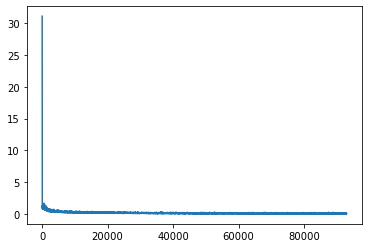

In [23]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label ,_,_,_,_ = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
        netname='./new_weights/weights_face/0807_SGDmomentum_1e-3/epoch-{} loss-{}.pkl'.format(epoch, loss_contrastive.item()) #파일명 변경
    if((epoch%10==0) or (epoch == Config.train_number_epochs-1)):
        torch.save(net, netname, )
show_plot(counter,loss_history)

In [ ]:
print(np.min(loss_history))

## Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

In [ ]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=0,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)

In [ ]:
gn=0 #genuine matching 횟수
gns=0 #genuine matching 성공횟수
gnf=0
In=0 #imposter matching 횟수
ins=0 #imposter matching 성공횟수
inf=0
while True: #Genuine matching에 대해서만 출력
    try:
        x0,x1,label,x0_folder,x1_folder,x0_fname,x1_fname = next(dataiter)
    
        if (x1_folder==x0_folder): #genuine
            gn+=1
            output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
            euclidean_distance = F.pairwise_distance(output1, output2)
            if (euclidean_distance<0.5):
                gns+=1

            else:
                gnf+=1
#                 concatenated = torch.cat((x0,x1),0)
#                 imshow(torchvision.utils.make_grid(concatenated),'distance: {:.2f}'.format(euclidean_distance.item()))
#                 print("왼쪽사진이름",x0_fname)
#                 print("오른쪽 사진이름" , x1_fname)
                
        elif(x1_folder!=x0_folder):
            In+=1
            output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
            euclidean_distance = F.pairwise_distance(output1, output2)
            if (euclidean_distance>0.5):
                ins+=1
            else:
                inf+=1
        
    except:break
        
print ("genuine matching 횟수", gn)  
print ("imposter matching 횟수", In)
print ("genuine matching 성공횟수", gns)  
print ("imposter matching 성공횟수", ins)
print ("genuine matching 성공률(TP)", float(gns)/gn)
print ("imposter matching 성공률(TN)", float(ins)/In)
print ("genuine matching FP", inf/In)
print ("imposter matching FN", gnf/gn)
print (float(gns)/gn + gnf/gn)
          